### Import Libraries

In [20]:
import numpy as np
import pandas as pd
from scipy.io import loadmat
import matplotlib.pyplot as plt
%matplotlib inline

In [88]:
from sklearn.linear_model import Ridge

In [223]:
from __future__ import print_function

import keras
from keras import metrics
from keras.datasets import mnist
from keras.models import Sequential
from keras.optimizers import RMSprop, SGD
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D, LeakyReLU
from keras.models import model_from_json
from keras.callbacks import EarlyStopping

### Get Data

In [317]:
fracture_data = loadmat('fracture.mat')['fracture']

In [318]:
stress_data = loadmat('stress.mat')['stress']
thickness_data = loadmat('thickness.mat')['thickness']

In [319]:
stress_data = np.nan_to_num(stress_data)
thickness_data = np.nan_to_num(thickness_data)

### Baseline Model:  Linear Regression
#### Prediction Correlation ~ 0.73, RMSE ~3.8k

In [320]:
# Baseline Model 1: Linear Regression

train_split = int(fracture_data.shape[1]/2)
valid_split = int(fracture_data.shape[1]*3/4)

fracture_train = fracture_data[:,:train_split].flatten()
stress_train = stress_data[:, :train_split].flatten()
thickness_train = thickness_data[:,:train_split].flatten()

fracture_valid = fracture_data[:, train_split:valid_split].flatten()
stress_valid = stress_data[:, train_split:valid_split].flatten()
thickness_valid = thickness_data[:, train_split:valid_split].flatten()

fracture_test = fracture_data[:, valid_split:].flatten()
stress_test = stress_data[:, valid_split:].flatten()
thickness_test = thickness_data[:, valid_split:].flatten()

In [321]:
train_x = np.transpose(np.array([stress_train, thickness_train]))
train_y = fracture_train

valid_x = np.transpose(np.array([stress_valid, thickness_valid]))
valid_y = fracture_valid

test_x = np.transpose(np.array([stress_test, thickness_test]))
test_y = fracture_test

alpha_list = [1e1, 1e2, 1e3, 1e4, 1e5, 1e6, 1e7, 1e8, 1e9, 1e10]

rmse_store = np.Inf
alpha_store = alpha_list[0]

for alpha in alpha_list:
    lr_model = Ridge(alpha = alpha)
    lr_model.fit(train_x, train_y)
    valid_y_predict = lr_model.predict(valid_x)
    rmse = sum((valid_y_predict - valid_y)**2)
    if rmse < rmse_store:
        alpha_store = alpha
        rmse_store = rmse

print(alpha_store)
lr_model_final = Ridge(alpha = alpha_store)
lr_model_final.fit(train_x, train_y)
test_y_predict = lr_model_final.predict(test_x)

10000000.0


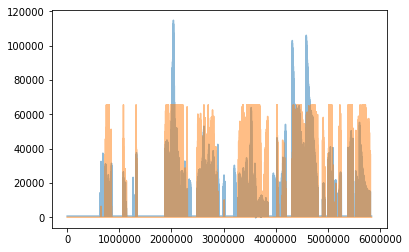

In [323]:
plt.plot(range(len(test_y)), test_y_predict, alpha = 0.5)
plt.plot(range(len(test_y)), test_y, alpha = 0.5)

In [324]:
np.corrcoef(test_y_predict.flatten(), test_y)[0][1]

0.7322036885828004

In [325]:
np.sqrt(np.mean((test_y_predict.flatten() - test_y.flatten())**2))

3213.3390996150347

### Model 1:  Simple 1-Layer Neural Network
#### Prediction Correlation ~ 0.84, RMSE = 3.8k

In [312]:
# Simple Neural Network

train_x = np.transpose(np.array([stress_train, thickness_train]))
train_y = fracture_train

train_x_mean, train_x_std = np.mean(train_x, axis = 0), np.std(train_x, axis = 0)
train_y_mean, train_y_std = np.mean(train_y), np.std(train_y)

train_x = (train_x - train_x_mean) / train_x_std
train_y = (train_y - train_y_mean) / train_y_std

valid_x = np.transpose(np.array([stress_valid, thickness_valid]))
valid_y = fracture_valid

valid_x = (valid_x - train_x_mean) / train_x_std
valid_y = (valid_y - train_y_mean) / train_y_std

test_x = np.transpose(np.array([stress_test, thickness_test]))
test_y = fracture_test

test_x = (test_x - train_x_mean) / train_x_std
test_y = (test_y - train_y_mean) / train_y_std

In [313]:
batch_size = 1024
epochs = 20

model = Sequential()
model.add(Dense(3, activation='relu', input_shape=(2,), kernel_initializer = 'random_uniform'))
model.add(Dense(1, activation='relu'))

model.summary()

model.compile(loss='mean_squared_error',
              optimizer=SGD(),
              metrics=[metrics.mse])

callback = [EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience=1,
                              verbose=0, mode='auto')]

history = model.fit(train_x, train_y,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(valid_x, valid_y),
                    callbacks = callback)

score = model.evaluate(test_x, test_y, verbose=0)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_61 (Dense)             (None, 3)                 9         
_________________________________________________________________
dense_62 (Dense)             (None, 1)                 4         
Total params: 13
Trainable params: 13
Non-trainable params: 0
_________________________________________________________________
Train on 11662650 samples, validate on 5831325 samples
Epoch 1/20
11662650/11662650 [==============================] - 20s 2us/step - loss: 0.2044 - mean_squared_error: 0.2044 - val_loss: 0.1581 - val_mean_squared_error: 0.15814 - mean_squared_error: 0.30 - ETA: 20s - loss: 0.2971 - me - ETA: 10s - loss: 0.2364 - mean_squared_error: 0.236 - ETA: 10s - loss: 0.2 - ETA: 8s - loss: 0.2301 - mean_squared_error: 0.23 - ETA: 8s - loss: 0.2297 - mean - ETA: 7s - loss: 0.2265 - mean_squared_error:  - ETA: 7s - loss: 0.2256 -  - ETA: 6s - loss: 

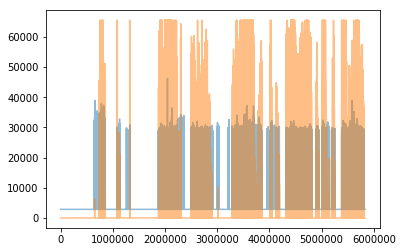

In [314]:
test_y_predict = model.predict(test_x)*train_y_std + train_y_mean
plt.plot(range(len(test_y)), test_y_predict, alpha = 0.5)
plt.plot(range(len(test_y)), test_y*train_y_std + train_y_mean, alpha = 0.5)

In [315]:
np.corrcoef(test_y_predict.flatten(), test_y)[0][1]

0.8356757665029602

In [316]:
np.sqrt(np.mean((test_y_predict.flatten() - (test_y * train_y_std + train_y_mean))**2))

3775.372706921231

### Model 2:  Conv 3D Neural Network
#### Prediction Correlation ~ 0.84, RMSE ~3.7k

In [288]:
# 3D Convolutional
stress_data = np.pad(stress_data, ((1, 1), (1, 1)), 'constant', 
                constant_values=((0, 0), (0, 0)))
thickness_data = np.pad(thickness_data, ((1, 1), (1, 1)), 'constant', 
                constant_values=((0, 0), (0, 0)))
fracture_data = np.pad(fracture_data, ((1, 1), (1, 1)), 'constant', 
                constant_values=((0, 0), (0, 0)))

In [289]:
stress_data = np.array([stress_data[(y-1):(y+2), (x-1):(x+2)] 
              for x in np.arange(1, stress_data.shape[1] - 1) 
              for y in np.arange(1, stress_data.shape[0] - 1)])

thickness_data = np.array([thickness_data[(y-1):(y+2), (x-1):(x+2)] 
              for x in np.arange(1, thickness_data.shape[1] - 1) 
              for y in np.arange(1, thickness_data.shape[0] - 1)])

fracture_data = np.array([fracture_data[y,x] 
              for x in np.arange(1, fracture_data.shape[1] - 1) 
              for y in np.arange(1, fracture_data.shape[0] - 1)])

In [290]:
train_split = int(fracture_data.shape[0]/2)
valid_split = int(fracture_data.shape[0]*3/4)

fracture_train = fracture_data[:train_split,...]
stress_train = stress_data[:train_split,...]
thickness_train = thickness_data[:train_split,...]

fracture_valid = fracture_data[train_split:valid_split,...]
stress_valid = stress_data[train_split:valid_split,...]
thickness_valid = thickness_data[train_split:valid_split,...]

fracture_test = fracture_data[valid_split:,...]
stress_test = stress_data[valid_split:,...]
thickness_test = thickness_data[valid_split:,...]

In [291]:
# Simple Neural Network

train_x = np.stack([stress_train, thickness_train], axis = 3)
train_y = fracture_train

train_x_mean, train_x_std = np.mean(train_x, axis = (0,1,2)), np.std(train_x, axis = (0,1,2))
train_y_mean, train_y_std = np.mean(train_y), np.std(train_y)

train_x = (train_x - train_x_mean) / train_x_std
train_y = (train_y - train_y_mean) / train_y_std

valid_x = np.stack([stress_valid, thickness_valid], axis = 3)
valid_y = fracture_valid

valid_x = (valid_x - train_x_mean) / train_x_std
valid_y = (valid_y - train_y_mean) / train_y_std

test_x = np.stack([stress_test, thickness_test], axis = 3)
test_y = fracture_test

test_x = (test_x - train_x_mean) / train_x_std
test_y = (test_y - train_y_mean) / train_y_std

In [292]:
batch_size = 1024
epochs = 20

model = Sequential()
    
model.add(Conv2D(16, kernel_size = (3,3), data_format = 'channels_last',
                     input_shape = train_x.shape[1:], kernel_initializer = 'random_uniform'))
model.add(Activation('relu'))

model.add(Flatten())
model.add(Dense(1, activation = 'relu'))

model.summary()

model.compile(loss='mean_squared_error',
              optimizer=SGD(),
              metrics=[metrics.mse])

callback = [EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience=1,
                              verbose=0, mode='auto')]

history = model.fit(train_x, train_y,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(valid_x, valid_y),
                    callbacks = callback)

score = model.evaluate(test_x, test_y, verbose=0)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 1, 1, 16)          304       
_________________________________________________________________
activation_3 (Activation)    (None, 1, 1, 16)          0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 16)                0         
_________________________________________________________________
dense_60 (Dense)             (None, 1)                 17        
Total params: 321
Trainable params: 321
Non-trainable params: 0
_________________________________________________________________
Train on 11664850 samples, validate on 5832425 samples
Epoch 1/20
11664850/11664850 [==============================] - 35s 3us/step - loss: 0.2040 - mean_squared_error: 0.2040 - val_loss: 0.1627 - val_mean_squared_error: 0.1627 - mean_squared_error: 0.23 - ETA: 34s - loss: 0.

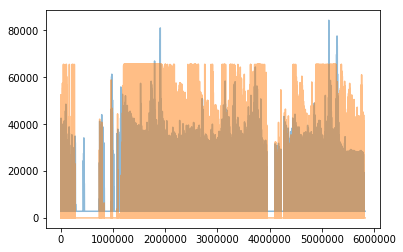

In [296]:
test_y_predict = model.predict(test_x)*train_y_std + train_y_mean

plt.plot(range(len(test_y)), test_y_predict, alpha = 0.5)
plt.plot(range(len(test_y)), test_y*train_y_std + train_y_mean, alpha = 0.5)

In [302]:
np.sqrt(np.mean((test_y_predict.flatten() - (test_y * train_y_std + train_y_mean))**2))

3720.4626239112963